In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import cv2
import random
# use pytorch (better support for 5070 ti on windows than tensorflow)

In [7]:
# following function will downscale photos
def bicubic_2x_downscale(hr_img_arr):
    height, width = hr_img_arr.shape[:2]
    
    new_width = width // 2
    new_height = height // 2
    
    lr_img_arr = cv2.resize(
        hr_img_arr, 
        (new_width, new_height), 
        interpolation=cv2.INTER_CUBIC
    )
    
    return lr_img_arr

In [ ]:
hr_dir = os.path.join(".", "div2k_images", "hr")
train_paths = glob.glob(os.path.join(hr_dir, "train", "*.png"))
val_paths = glob.glob(os.path.join(hr_dir, "val", "*.png"))

train_y = []
train_x = []
for path in train_paths:
    img = Image.open(path)
    img_arr = np.array(img)
    # if odd resolution, strip last row or column
    # row
    if img_arr.shape[0] % 2 == 1:
        img_arr = img_arr[:-1, :, :] 
    # col
    if img_arr.shape[1] % 2 == 1:
        img_arr = img_arr[:, :-1, :]
    train_x.append(bicubic_2x_downscale(img_arr))
    train_y.append(img_arr)

val_y = []
val_x = []
for path in val_paths:
    img = Image.open(path)
    img_arr = np.array(img)
    # row
    if img_arr.shape[0] % 2 == 1:
        img_arr = img_arr[:-1, :, :] 
    # col
    if img_arr.shape[1] % 2 == 1:
        img_arr = img_arr[:, :-1, :]
    val_x.append(bicubic_2x_downscale(img_arr))
    val_y.append(img_arr)

In [10]:
print(train_x[1].shape)
print(train_y[1].shape)

(924, 1020, 3)
(1848, 2040, 3)


In [11]:
# break up images into randomly sampled x by x patches for the low res photos
# outputs tuple of high res patches and corresponding low res patches
def createPatches(hr: list, lr: list, patch_size: int, sample_per_image: int) -> tuple:
    if len(hr) != len(lr):
        raise ValueError("The HR and LR lists must contain the same number of images.")
    
    hr_patches = []
    lr_patches = []

    for hr_img, lr_img in zip(hr, lr):
        lr_h, lr_w = lr_img.shape[:2]

        if lr_h < patch_size or lr_w < patch_size:
            raise ValueError("The patch_size must not be larger than the width or height of any image in the LR list.")
        
        for _ in range(sample_per_image):
            # 1. Randomly sample top-left coordinate (x, y) from the Low Res image
            # limits are (width - patch_size) and (height - patch_size)
            lr_x = random.randint(0, lr_w - patch_size)
            lr_y = random.randint(0, lr_h - patch_size)
            
            # 2. Calculate the corresponding coordinates for the High Res image
            # Since HR is 2x LR, we multiply coordinates and size by 2
            hr_x = lr_x * 2
            hr_y = lr_y * 2
            hr_patch_size = patch_size * 2
            
            # 3. Crop the blocks
            # Slicing syntax: image[y : y + height, x : x + width]
            lr_patch = lr_img[lr_y : lr_y + patch_size, lr_x : lr_x + patch_size]
            hr_patch = hr_img[hr_y : hr_y + hr_patch_size, hr_x : hr_x + hr_patch_size]
            
            hr_patches.append(hr_patch)
            lr_patches.append(lr_patch)

    # Convert lists to numpy arrays
    return np.array(hr_patches), np.array(lr_patches)
        
train_y, train_x = createPatches(train_y, train_x, 32, 30)

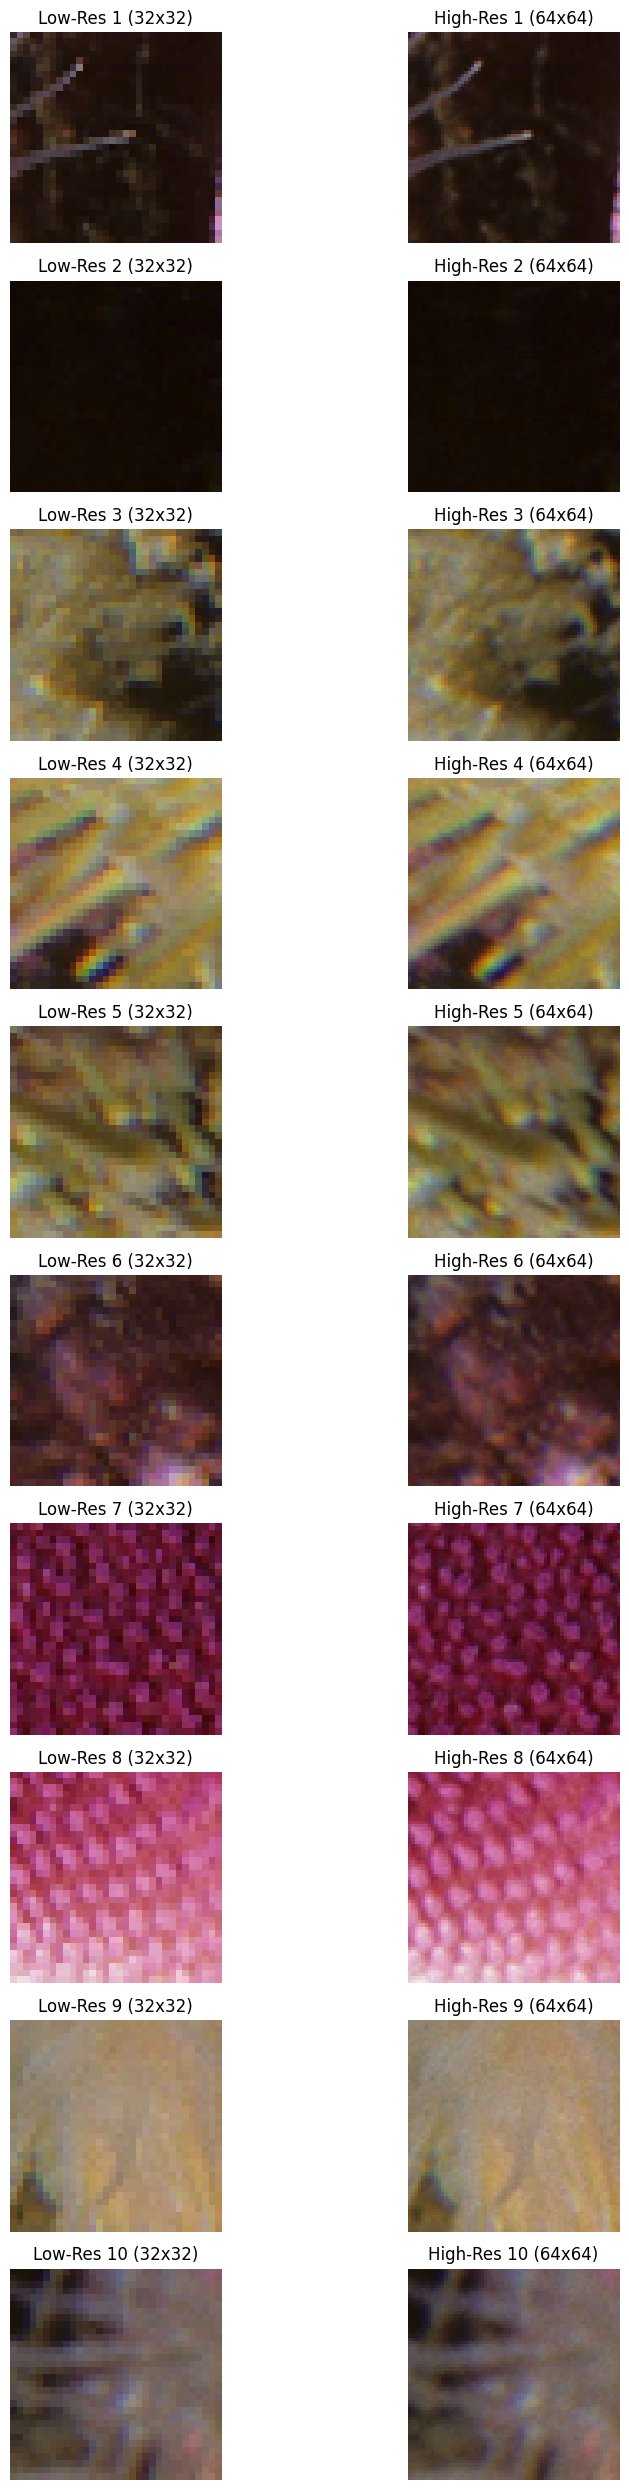

In [14]:
# Display first 10 images from train_y and train_x side by side
fig, axes = plt.subplots(10, 2, figsize=(10, 25))

for i in range(10):
    # Display low-res image (train_x) on the left
    axes[i, 0].imshow(train_x[i])
    axes[i, 0].set_title(f'Low-Res {i+1} ({train_x[i].shape[0]}x{train_x[i].shape[1]})')
    axes[i, 0].axis('off')
    
    # Display high-res image (train_y) on the right
    axes[i, 1].imshow(train_y[i])
    axes[i, 1].set_title(f'High-Res {i+1} ({train_y[i].shape[0]}x{train_y[i].shape[1]})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [15]:
print(train_x.shape)
print(train_y.shape)

(24000, 32, 32, 3)
(24000, 64, 64, 3)


In [6]:
# Create super-resolution model
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2DTranspose(
            filters=64,
            kernel_size=11,
            strides=4,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters=32,
            kernel_size=9,
            strides=2,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters = 16,
            kernel_size=9,
            strides=1,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters = 16,
            kernel_size=9,
            strides=1,
            padding='same',
            activation='sigmoid'
        ),
        layers.Conv2DTranspose(
            filters = 3,
            kernel_size=5,
            strides=1,
            padding='same',
            activation='sigmoid'
        ),
        layers.AveragePooling2D(pool_size=(2,2)),
        layers.AveragePooling2D(pool_size=(2,2))
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = create_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_6              │ (None, 128, 128, 64)   │        23,296 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 256, 256, 32)   │       165,920 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 256, 256, 16)   │        41,488 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 16)   │        20,752 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 256, 256, 3)    │         1,203 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 128, 128, 3)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 64, 64, 3)      │             0 │
│ (AveragePooling2D)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,659 (986.95 KB)

 Trainable params: 252,659 (986.95 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Calculate the number of batches (steps)
# Since batch size is 1, steps = number of images
num_train_steps = len(train_val_split['train'])
num_val_steps = len(train_val_split['test'])

print(f"Training steps per epoch: {num_train_steps}")
print(f"Validation steps per epoch: {num_val_steps}")

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    steps_per_epoch=num_train_steps,  
    validation_steps=num_val_steps   
)

NameError: name 'train_val_split' is not defined

In [ ]:
# Calculate the number of test batches
# Since batch size is 1, steps = number of images
num_test_steps = len(ds['test'])

print(f"Test steps: {num_test_steps}")
print("Evaluating model on the test set...")
loss, mae = model.evaluate(
    test_dataset,
    steps=num_test_steps
)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

Test steps: 320
Evaluating model on the test set...
 70/320 ━━━━━━━━━━━━━━━━━━━━ 56s 227ms/step - loss: 0.0170 - mae: 0.1106

KeyboardInterrupt: 